In [60]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import calendar
from scipy.stats import pearsonr

%matplotlib inline

In [61]:
reviews = pd.read_csv('./Amsterdam/reviews2.csv')
listings_desc = pd.read_csv('./Amsterdam/listings2.csv')
listings = pd.read_csv('./Amsterdam/listings.csv')
neighbour = pd.read_csv('./Amsterdam/neighbourhoods.csv')
calendar2 = pd.read_csv('./Amsterdam/calendar.csv')

#C:\Users\avadi\Desktop\DataScience_Udacity\Project 1\Amsterdam

## Pre-process Data 

### Calendar Data

In [62]:
# Looking for nulls
calendar2.isnull().sum()

# Looking for listings where price is null
calendar2[calendar2.price.isnull()].listing_id.unique()


array([          12550549,           32234160,           37591658,
                 37614789, 720266014528319438,           18631508],
      dtype=int64)

In [63]:
# It is safe to drop all rows that have null values as there are very little days/listings where the price is missing
calendar_clean = calendar2.dropna()


In [64]:
# Number listings in/around Amsterdam = 6809
len(calendar_clean.dropna().listing_id.unique().tolist())

6809

In [65]:
calendar_clean['available']  = np.where(calendar_clean['available']=='t' , 1, 0)
calendar_clean['year'] = pd.to_datetime(calendar_clean['date']).dt.year
calendar_clean['month'] = pd.to_datetime(calendar_clean['date']).dt.month
calendar_clean['day'] = pd.to_datetime(calendar_clean['date']).dt.day_name()

<ipython-input-65-58eccb52175d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['available']  = np.where(calendar_clean['available']=='t' , 1, 0)
<ipython-input-65-58eccb52175d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['year'] = pd.to_datetime(calendar_clean['date']).dt.year
<ipython-input-65-58eccb52175d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [66]:
x = ['listing_id', 'year', 'month', 'day', 'minimum_nights','maximum_nights']
calendar_clean[["price", "adjusted_price"]] = calendar_clean[["price", "adjusted_price"]].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',','')).apply(pd.to_numeric)
calendar_clean = calendar_clean[calendar_clean['price'] <= 2000]
calendar_clean = calendar_clean.groupby(x, as_index = False, group_keys = False).aggregate({'available':'sum','price':['mean'],'adjusted_price':'mean'})
calendar_clean.columns = calendar_clean.columns.droplevel(1)

<ipython-input-66-de0bdc6eecf8>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  calendar_clean[["price", "adjusted_price"]] = calendar_clean[["price", "adjusted_price"]].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',','')).apply(pd.to_numeric)
c:\Users\avadi\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [67]:
calendar_clean.head(20)

,listing_id,year,month,day,minimum_nights,maximum_nights,available,price,adjusted_price
0,2818,2022,12,Friday,3,1125,0,69.00,69.00
1,2818,2022,12,Monday,3,1125,1,59.00,59.00
2,2818,2022,12,Saturday,3,1125,0,69.25,69.25
3,2818,2022,12,Sunday,3,1125,0,59.00,59.00
4,2818,2022,12,Thursday,3,1125,0,69.00,69.00
5,2818,2022,12,Tuesday,3,1125,2,59.00,59.00
6,2818,2022,12,Wednesday,3,1125,2,69.00,69.00
7,2818,2023,1,Friday,3,1125,3,59.00,59.00
8,2818,2023,1,Monday,3,1125,3,67.00,67.00
9,2818,2023,1,Saturday,3,1125,3,59.00,59.00


### Listings Data

In [68]:
listings.isnull().sum()
listings_clean = listings.drop(['license', 'neighbourhood_group', 'number_of_reviews_ltm',
                                 'last_review', 'host_id','host_name'], axis=1)
sum(listings_clean.reviews_per_month.isnull() == (listings_clean['number_of_reviews'] == 0))

6809

In [71]:
listings_clean.isnull().sum()
sum(listings.reviews_per_month.isnull() == (listings['number_of_reviews'] == 0))
listings_clean['reviews_per_month'] = listings_clean['reviews_per_month'].fillna(0)
#listings_clean['price'] =  listings_clean['price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
listings_clean = listings_clean[listings_clean['price'] <= 2000]

In [72]:
listings_clean.head(20)

,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,816940,Old South Lovely Garden Apartment,Zuid,52.35323,4.85421,Entire home/apt,165,6,63,0.54,1,11
1,528022,Somewhere Else,Westerpark,52.39114,4.88846,Private room,100,2,248,3.30,1,212
2,538723,Beautiful ground floor apartment,Watergraafsmeer,52.35400,4.93965,Entire home/apt,140,5,57,0.45,1,0
3,549310,Family Apartment with Garden,De Baarsjes - Oud-West,52.37126,4.86241,Entire home/apt,200,2,54,0.60,1,7
4,553514,"B&B WestergasTverblijf , Cosy!",Westerpark,52.38444,4.86916,Entire home/apt,80,2,162,1.34,1,1
5,2818,Quiet Garden View Room & Super Fast Wi-Fi,Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room,59,3,314,1.88,1,27
6,20168,Studio with private bathroom in the centre 1,Centrum-Oost,52.36407,4.89393,Private room,106,1,339,2.18,2,0
7,27886,"Romantic, stylish B&B houseboat in canal district",Centrum-West,52.38761,4.89188,Private room,140,2,243,1.83,1,40
8,28871,Comfortable double room,Centrum-West,52.36775,4.89092,Private room,75,2,454,3.03,2,91
9,29051,Comfortable single room,Centrum-Oost,52.36584,4.89111,Private room,55,2,602,4.22,2,142


In [73]:
listings_desc_clean = listings_desc.drop(['listing_url','scrape_id','last_scraped','source',
                                          'name','description','neighborhood_overview',
                                          'picture_url','host_id', 'host_url','host_name',
                                          'host_location','host_about', 'host_thumbnail_url',
                                          'host_picture_url','host_neighbourhood','host_listings_count',
                                          'host_verifications','host_has_profile_pic','host_identity_verified',
                                          'license', 'neighbourhood','neighbourhood_cleansed',
                                          'neighbourhood_group_cleansed','latitude','longitude', 
                                          'calculated_host_listings_count',
                                          'calculated_host_listings_count_entire_homes',
                                          'calculated_host_listings_count_private_rooms',
                                          'calculated_host_listings_count_shared_rooms',
                                          'minimum_minimum_nights', 'maximum_minimum_nights',
                                          'minimum_maximum_nights', 'maximum_maximum_nights',
                                          'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
                                          'minimum_nights', 'maximum_nights','has_availability', 
                                          'availability_30', 'availability_60', 'availability_90',
                                          'calendar_last_scraped','bathrooms','first_review', 'last_review',
                                          'host_response_time','host_response_rate', 'host_acceptance_rate','host_is_superhost',
                                          'number_of_reviews', 'number_of_reviews_ltm','number_of_reviews_l30d','host_total_listings_count'], axis=1)


listings_desc_clean['review_scores_rating'] = listings_desc_clean['review_scores_rating'].fillna(0)
listings_desc_clean['review_scores_accuracy'] = listings_desc_clean['review_scores_accuracy'].fillna(0)
listings_desc_clean['review_scores_cleanliness'] = listings_desc_clean['review_scores_cleanliness'].fillna(0)
listings_desc_clean['review_scores_checkin'] = listings_desc_clean['review_scores_checkin'].fillna(0)
listings_desc_clean['review_scores_communication'] = listings_desc_clean['review_scores_communication'].fillna(0)
listings_desc_clean['review_scores_location'] = listings_desc_clean['review_scores_location'].fillna(0)
listings_desc_clean['review_scores_value'] = listings_desc_clean['review_scores_value'].fillna(0)
listings_desc_clean['reviews_per_month'] = listings_desc_clean['reviews_per_month'].fillna(0)
listings_desc_clean['price'] =  listings_desc_clean['price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
listings_desc_clean = listings_desc_clean[listings_desc_clean['price'] <= 2000]

In [74]:
listings_desc_clean.isnull().sum()

id                               0
host_since                       0
property_type                    0
room_type                        0
accommodates                     0
bathrooms_text                  13
bedrooms                       286
beds                            91
amenities                        0
price                            0
availability_365                 0
review_scores_rating             0
review_scores_accuracy           0
review_scores_cleanliness        0
review_scores_checkin            0
review_scores_communication      0
review_scores_location           0
review_scores_value              0
instant_bookable                 0
reviews_per_month                0
dtype: int64

## Analysis

### Does the time of the year affect Air BnB availability?

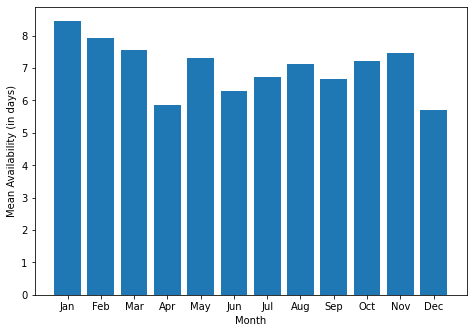

In [75]:
month_avail = calendar_clean.groupby(['listing_id','month'], as_index = False, group_keys = False).aggregate({'available':'sum'})
month_avail = month_avail.groupby(['month'], as_index = False, group_keys = False).aggregate({'available':'mean'})
month_avail['month'] = month_avail['month'].apply(lambda x: calendar.month_abbr[x])

#month_avail

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(month_avail['month'],month_avail['available'])
plt.xlabel("Month")
plt.ylabel("Mean Availability (in days)")
plt.show()

<ipython-input-85-1d01f4a77bc6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean2['available']  = np.where(calendar_clean2['available']=='t' , 1, 0)
<ipython-input-85-1d01f4a77bc6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean2['year'] = pd.to_datetime(calendar_clean2['date']).dt.year
<ipython-input-85-1d01f4a77bc6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

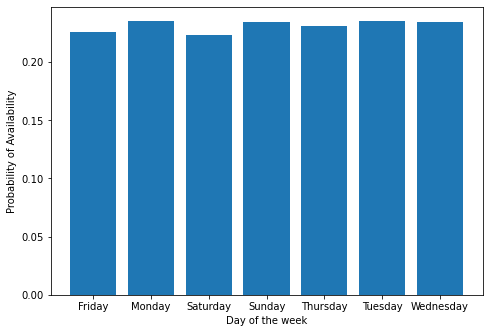

In [85]:
calendar_clean2 = calendar2.dropna()
calendar_clean2['available']  = np.where(calendar_clean2['available']=='t' , 1, 0)
calendar_clean2['year'] = pd.to_datetime(calendar_clean2['date']).dt.year
calendar_clean2['month'] = pd.to_datetime(calendar_clean2['date']).dt.month
calendar_clean2['day'] = pd.to_datetime(calendar_clean2['date']).dt.day_name()


day_avail = calendar_clean2.groupby(['day'], as_index = False, group_keys = False).aggregate({'available':'mean'})


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(day_avail['day'],day_avail['available'])
plt.xlabel("Day of the week")
plt.ylabel("Probability of Availability")
plt.show()
#day_avail.available.mean()

### Do reviews affect Air BnB availability?

In [76]:
# listings_desc_clean.plot.line('review_scores_rating', 'availability_365')

rho = listings_desc_clean[['review_scores_rating', 'availability_365']].corr()
pval = listings_desc_clean[['review_scores_rating', 'availability_365']].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(4).astype(str) + p

,review_scores_rating,availability_365
review_scores_rating,1.0***,-0.1102***
availability_365,-0.1102***,1.0***


In [88]:
rho = listings_desc_clean[['reviews_per_month', 'availability_365']].corr()
pval = listings_desc_clean[['reviews_per_month', 'availability_365']].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(4).astype(str) + p

,reviews_per_month,availability_365
reviews_per_month,1.0***,0.208***
availability_365,0.208***,1.0***


### Does the neighbourhood group affect Air BnB availability?

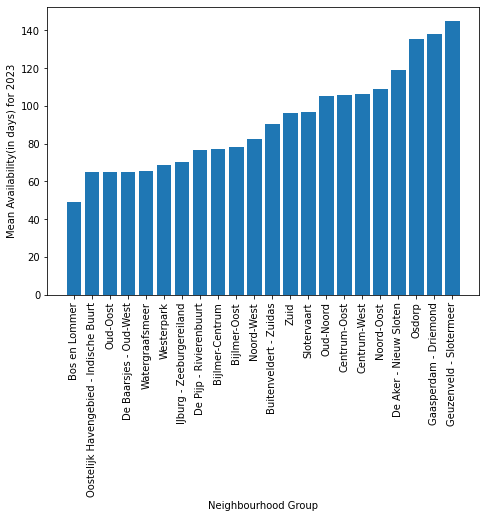

In [78]:
neigh_avail = listings_clean.groupby(['neighbourhood'], as_index = False, group_keys = False).aggregate({'availability_365':'mean'})
neigh_avail = neigh_avail.sort_values(by='availability_365')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(neigh_avail['neighbourhood'],neigh_avail['availability_365'])
plt.xticks(rotation=90)
plt.xlabel("Neighbourhood Group")
plt.ylabel("Mean Availability(in days) for 2023")
plt.show()

### Does the type of home affect Air BnB availability?

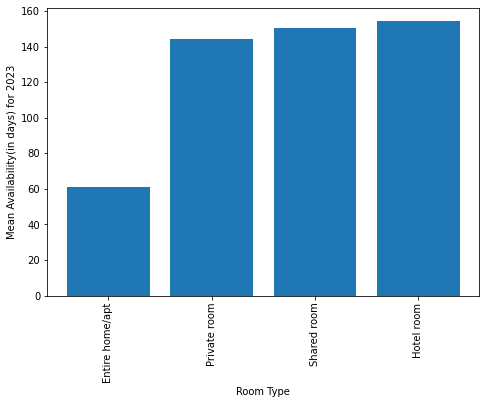

In [79]:
roomtyp_avail = listings_clean.groupby(['room_type'], as_index = False, group_keys = False).aggregate({'availability_365':'mean'})
roomtyp_avail = roomtyp_avail.sort_values(by='availability_365')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(roomtyp_avail['room_type'],roomtyp_avail['availability_365'])
plt.xticks(rotation=90)
plt.xlabel("Room Type")
plt.ylabel("Mean Availability(in days) for 2023")
plt.show()

### Does the price of the space affect Air BnB availability?

In [80]:
##listings_desc_clean.plot.line('review_scores_rating', 'availability_365')


rho = listings_desc_clean[['price', 'availability_365']].corr()
pval = listings_desc_clean[['price', 'availability_365']].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(4).astype(str) + p

,price,availability_365
price,1.0***,0.1078***
availability_365,0.1078***,1.0***


In [82]:
#calendar.join(listings, index='listing_id', lsuffix="_left", rsuffix="_right")

#pd.merge(calendar_clean, listings, on=['listing_id','id'])

#x = (pd.merge(calendar_clean, listings_clean, left_on='listing_id', right_on='id'))
#x_2818 = 
#sum(x[x['listing_id'] == 2818]['available'])
#listings[listings['id'] == 2818]
#calendar[calendar.listing_id == 2818]

